# COMP24112 - Exercise 3: _Face Recognition_ (25 Marks)

## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

You will be marked for your code presentation, design, results, and report. Please note this notebook should take no more than 10 minutes to run on lab computers. 

## 2. Preparation

### 2.1 Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [1]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt


Now you can load the data:

In [2]:
data, labels = load_data()

### 2.2 Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

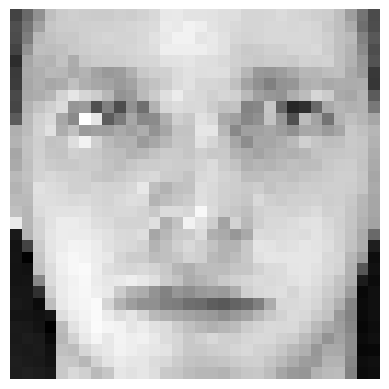

In [3]:
# Display a single example.
show_single_face(data[0, :])

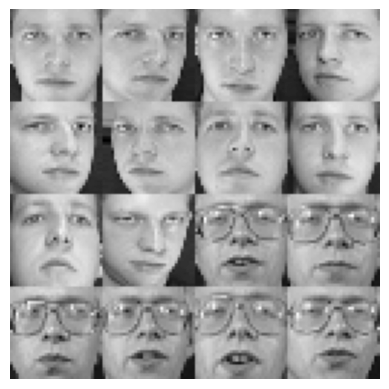

In [4]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### 2.3 Splitting into the train and test sets

First, normalize your pixel values by 1/255 so that the feature values used in later experiments are between $[0,1]$. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments.

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. The function takes the labels and the specified number $N$ as the input. And returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [5]:

#normalise data
data = data/255

## 3. $L_2$-regularised least squares (5 marks, Normal)
### 3.1 Implementation
Now, you need to implement the function `l2_rls_train` below. 

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ (lambda) as the input, and return the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [6]:
def l2_rls_train(data, labels, lmda): # Add any other arguments here
    """
    A summary of your function goes here.

    data: training data as one of the input variables
    labels: training labels as one of the input variables
    lmbd: lambda value can be set

    Returns: weight vector w used to predict labels later on
    """
    #To follow notes consistency, we will use X for data and y for labels
    X, y = data, labels
    #Add bias term to X
    X_tilde = np.hstack((np.ones((X.shape[0],1)),X))
    
    #Multiply X_tilde by its transpose
    XtX_tilde = np.dot(X_tilde.T,X_tilde)

    #find weight based on l2 regularisation formula
    if lmda == 0:
        w = np.dot(np.dot(np.linalg.pinv(XtX_tilde),X_tilde.T) ,y)
    else:
        w = np.dot(np.dot(np.linalg.inv(XtX_tilde + lmda * np.eye(X_tilde.shape[1])),X_tilde.T) ,y)

    return w

Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [7]:
def l2_rls_predict(w, data):
    """
    A summary of your function goes here.

    data: testing data as one of the input variables
    w: trained weight vector

    Returns: predicted labels
    """
    
   # Compute the prediction.
    data_tilde = np.hstack((np.ones((data.shape[0],1)),data))
    predicted_y = np.dot(data_tilde, w)        
    return predicted_y

### 3.2 Report

Explain briefly the knowledge supporting your implementation and your design step by step. Explicitly comment on the role of any arguments you have added to your functions. 

## 4. Face Recognition (4 Marks, Normal)
### 4.1 Implementation and experiment design

Use your implemented functions to perform multi-class classification to identify the subject in each image, for all 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, you should construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

Write your code below and make sure it compiles. 

In [37]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

#split data into training and testing
tr_ind, te_ind = partition_data(labels, num_per_class=5)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

#Encode labels
encoder = OneHotEncoder()
onelabels = encoder.fit_transform(labels.reshape(-1,1)).toarray()
tr_labels_encoded = encoder.fit_transform(tr_label.reshape(-1,1)).toarray()
te_labels_encoded = encoder.transform(te_label.reshape(-1,1)).toarray()

def hyperSelect(train_data, train_labels):
    # Define the lambda hyperparameters to search over
    alpha_values = [0,0.001, 0.01, 0.1, 1.0,10,100]
    train_frac_values = [0.6, 0.7, 0.8, 0.9] # Define the training fraction hyperparameters to search over

    # Define variables to keep track of the best hyperparameters and accuracy
    best_accuracy = 0
    best_hyperparams = {}

    # Iterate over all combinations of hyperparameters
    for alpha in alpha_values:
        for train_frac in train_frac_values:
            # Split the training data into training and validation sets
            train_data_part, val_data_part, train_labels_part, val_labels_part = train_test_split(train_data, train_labels, train_size=train_frac, random_state=42)

            # Train the model using the current hyperparameters
            w = l2_rls_train(train_data_part, train_labels_part, alpha)

            # Make predictions on the validation set
            val_pred = l2_rls_predict(w, val_data_part)

            # Convert the predicted labels to integer format
            val_pred_int = np.argmax(val_pred, axis=1)

            # Convert the validation labels to integer format
            val_labels_int = np.argmax(val_labels_part, axis=1)

            # Calculate the accuracy score
            accuracy = accuracy_score(val_labels_int, val_pred_int) 

            # Check if the current hyperparameters are the best so far
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_hyperparams = alpha

    return best_hyperparams

#select best hyperparameter
lmda = hyperSelect(tr_data, tr_labels_encoded)
print("Best hyperparameter selected: ")
print(lmda)
w = l2_rls_train(tr_data, tr_labels_encoded, lmda)
te_pred = l2_rls_predict(w,te_data)

# convert the predicted labels to integer format
te_pred_int = np.argmax(te_pred, axis=1)

# convert the test labels to integer format
te_label_int = np.argmax(te_labels_encoded, axis=1)

# calculate the confusion matrix
cm = confusion_matrix(te_label_int, te_pred_int)
accuracy = np.trace(cm) / np.sum(cm)
print(cm)
print("Accuracy: ")
print(accuracy * 100) 

Best hyperparameter selected: 
0
[[3 0 1 ... 0 0 1]
 [0 5 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [1 0 0 ... 0 0 4]]
Accuracy: 
91.5


 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

Class 2: accuracy = 1.00
Class 24: accuracy = 1.00
Class 8: accuracy = 1.00
Class 9: accuracy = 1.00
Class 10: accuracy = 1.00


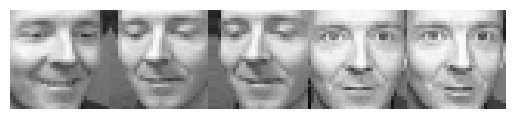

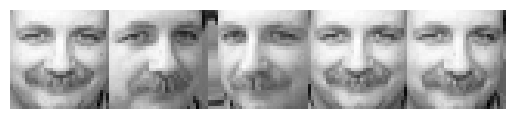

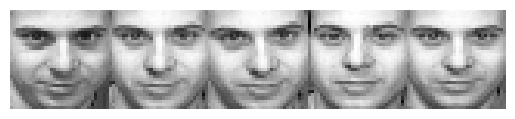

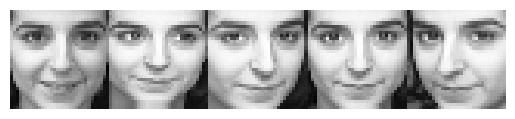

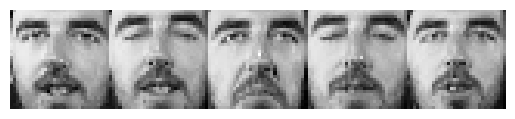

In [38]:

# calculate the accuracy for each class
class_acc = np.zeros(40)
for i in range(40):
    class_acc[i] = cm[i, i] / np.sum(cm[i, :])

# find the indices of the classes with the highest accuracy values, put in array
best_classes = np.argsort(class_acc)[::-1][:5] # get the top 5 classes with highest accuracy
for i in range(len(best_classes)):
    print(f"Class {best_classes[i]}: accuracy = {class_acc[best_classes[i]]:.2f}")
    show_faces(te_data[best_classes[i]*5 :best_classes[i]*5 + 5, :], num_per_row=5)
    

 Pick some subjects that are considered the most difficult to recognise by your classifier, and print the misclassified test images from these subjects below.

[ 0 12 19 22 27]
Class 0: 60.0%
Class 12: 60.0%
Class 19: 60.0%
Class 22: 60.0%
Class 27: 60.0%


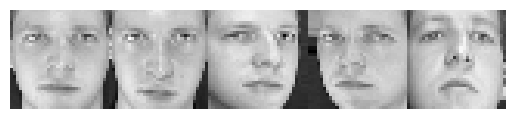

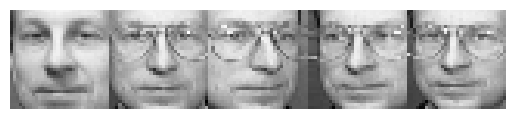

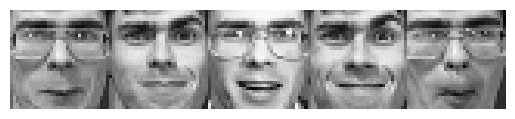

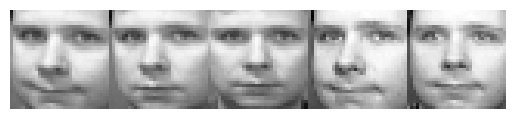

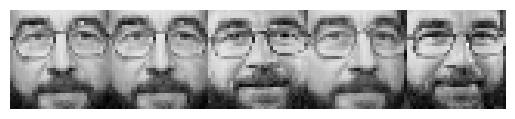

In [39]:
# find the indices of the classes with the lowest accuracy values, put in array
worst_classes = np.argwhere(class_acc < 0.8).flatten()

#shows the worst classes
print(worst_classes)
for c in worst_classes:
    print(f"Class {c}: {class_acc[c]*100}%")
    show_faces(te_data[c*5 :c*5 + 5, :], num_per_row=5)

    


### 4.2 Report

Explain the classification steps, and report your chosen hyper-parameter and results on the test set. Did you notice any common features among the easiest and most difficult subjects to classify? Describe your observations and analyse your results.

## 5. Face Completion (4 Marks, Normal)
In this task you will predict the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [11]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

In [12]:
# show_split_faces(left[:6, :], num_per_row=3)
# show_split_faces(right[:6, :], num_per_row=3)

### 5.1 Implementation and experiment design

Build a face completion model using your regularised least squares model. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error (MAPE) to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

In [13]:
trainInd, testInd = partition_data(labels, num_per_class=5)
train_dataL = left[trainInd, :]
train_dataR = right[trainInd, :]
train_label = labels[trainInd]

test_data = left[testInd, :]
test_label = labels[testInd]

true_data = right[testInd,:]

train_labels_encoded = encoder.fit_transform(train_label.reshape(-1,1)).toarray()
test_labels_encoded = encoder.transform(test_label.reshape(-1,1)).toarray()


weight = l2_rls_train(train_dataL, train_dataR,0)

#predict results
result_pred = l2_rls_predict(weight, test_data)

# convert the predicted labels to integer format
result_pred_int = np.argmax(result_pred, axis=1)

# convert the test labels to integer format
test_label_int = np.argmax(test_labels_encoded, axis=1)

mape = np.mean(np.abs((true_data - result_pred) / true_data))
print(mape)

0.21758531019015792


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

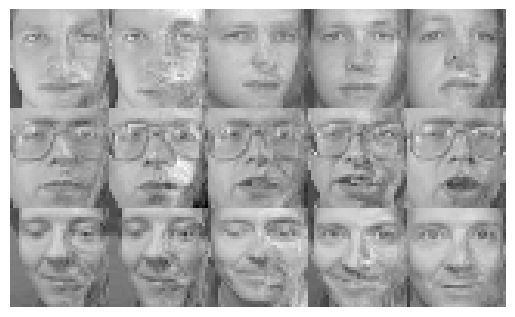

In [14]:
joined = join_left_right(test_data,result_pred)
show_faces(joined[0:15, :], num_per_row=5) 


### 5.2 Report

Report the MAPE and make some observations regarding the results of the face completion model. How well has your model performed? Offer one suggestion for how it can be improved.


## 6. Training linear least squares model via gradient descent (5 marks, Normal)
For these experiments you will be performing **binary classification.** 
### 6.1 GD Implementation
Now, implement the function `lls_gd_train` below. 

`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [15]:
def lls_gd_train(data, labels, N, lr):
    """
    A summary of your function goes here.

    data: training data
    labels: training labels
    N: number of iterations
    lr: learning rate
    
    Returns:  cost and weights for each iteration into 2 arrays
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    X_tilde = np.hstack((np.ones((X.shape[0],1)),X))
    
    # Weight initialization
    w = np.zeros(X_tilde.shape[1])

    # Initialise arrays to store weights and cost at each iteration
    w_all = np.zeros((N, X_tilde.shape[1]))
    cost_all = np.zeros(N)
    
    # GD update of weights
    for i in range(N):
        a = X_tilde.T@X_tilde
        gd = (a @ w) - (X_tilde.T@y)
        cost = np.sum(np.square(y-X_tilde@w)) / y.shape[0]
        
        # Weight update
        w -= lr * gd
        w_all[i,:] = w
        cost_all[i] = cost
        # save w and cost of each iteration in w_all and cost_all 
      
    
    
    # Return model parameters.
    return cost_all, w_all

In [16]:
def lls_gd_pred(data,w,labels):
    """
    A summary of your function goes here.

    data: testing data
    labels:testing labels
    w: weights from training model

    Returns: predicted labels
    """
    
    # Expand testing data with a column of ones.
    dataT = np.hstack((np.ones((data.shape[0],1)),data))
    predict = np.matmul(dataT,w)
    threshold = (np.max(labels) + np.min(labels)) / 2
    
    results = []
    for x in predict:
        if x > threshold:
            results.append(np.max(labels))
        else:
            results.append(np.min(labels))
           
    return results

### 6.2 Experiments

Apply this function to classify images from subject 1 and subject 30. You only need to conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set your learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train your model. Plot in three figures (1) the change of your sum-of-squares error loss that you minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations. Write your code below and make sure it runs. 

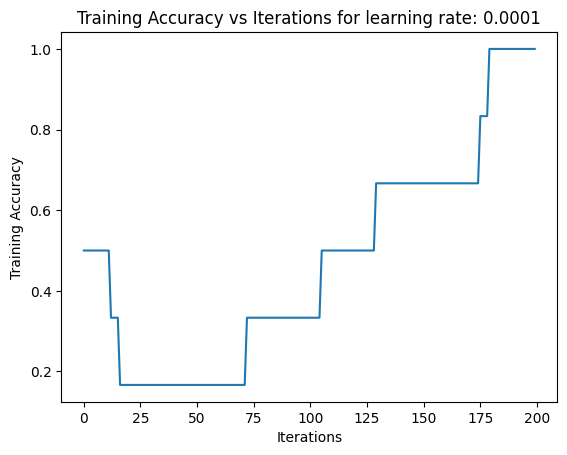

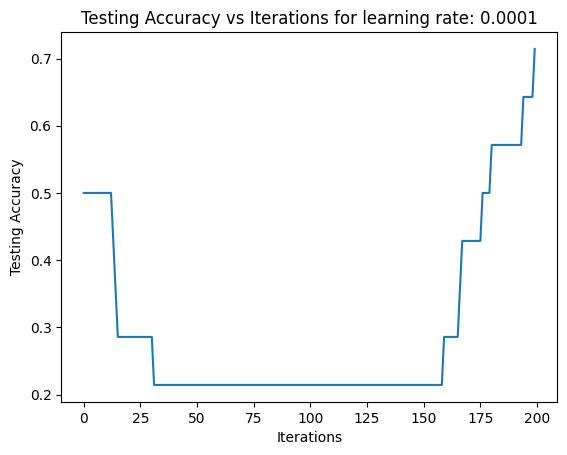

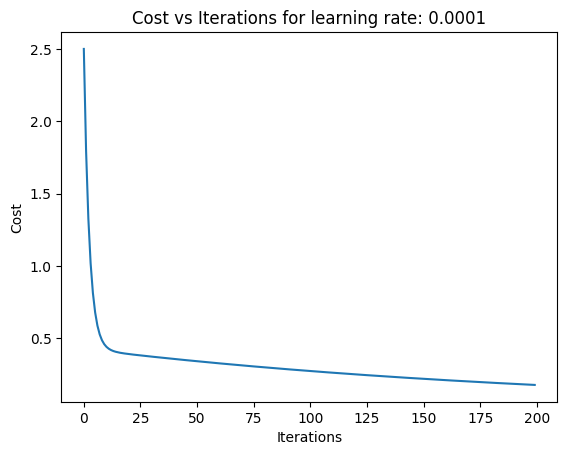

In [17]:
import matplotlib.pyplot as plt
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

indexx = np.concatenate((np.where(labels == 1)[0], np.where(labels == 30)[0]))
dataa = data[indexx]
indexx = label_encoder.fit_transform(indexx)
labelss = labels[indexx]
trainI, testI = partition_data(labelss, num_per_class=3)

trnLabel = labelss[trainI]
trnData = dataa[trainI,:]
tstLabel = labelss[testI]
tstData = dataa[testI,:]

def plot3Graphs(trnData,trnLabel,tstData,tstLabel,N,lr):
    test_acc = []
    train_acc = []
    cst,wgt = lls_gd_train(trnData,trnLabel,N,lr)
    for i in range(len(wgt)):
        test_pred = lls_gd_pred(tstData, wgt[i], tstLabel)
        test_acc.append((test_pred == tstLabel).mean())
        
        train_pred = lls_gd_pred(trnData, wgt[i], trnLabel)
        train_acc.append((train_pred == trnLabel).mean())
        
    # Plot training accuracy
    plt.plot(range(len(train_acc)), train_acc)
    plt.xlabel('Iterations')
    plt.ylabel('Training Accuracy')
    plt.title('Training Accuracy vs Iterations for learning rate: ' + str(lr))
    plt.show()

    # Plot testing accuracy
    plt.plot(range(len(test_acc)), test_acc)
    plt.xlabel('Iterations')
    plt.ylabel('Testing Accuracy')
    plt.title('Testing Accuracy vs Iterations for learning rate: ' + str(lr))
    plt.show()

    # Plot cost vs iterations
    plt.plot(range(len(cst)), cst)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost vs Iterations for learning rate: ' + str(lr))
    plt.show()  
    

plot3Graphs(trnData,trnLabel,tstData,tstLabel,200,0.0001)





Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it runs. 

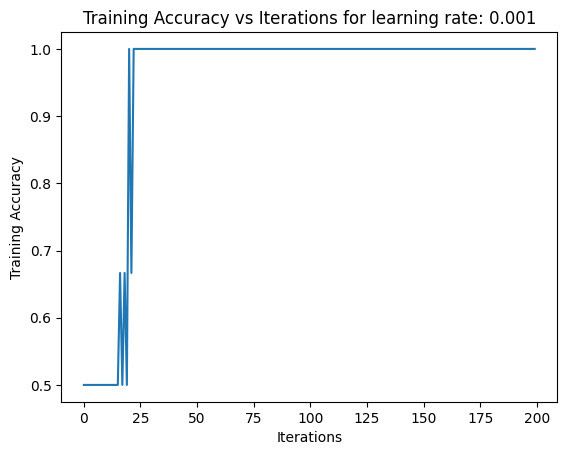

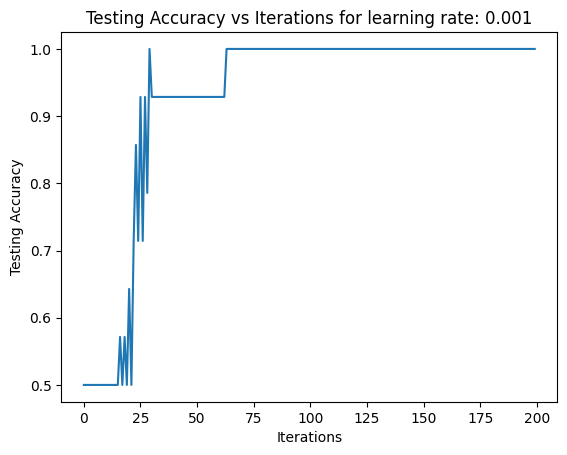

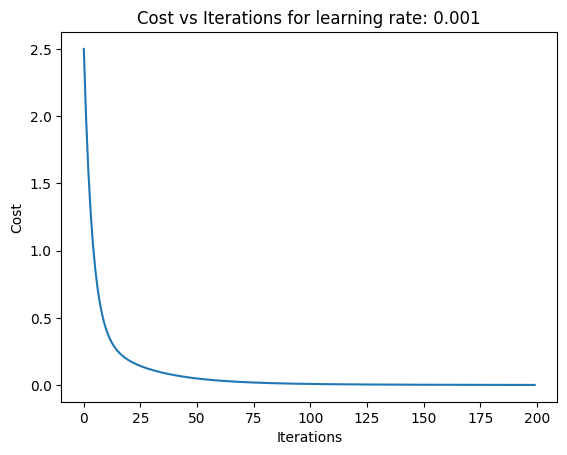

C:\Users\Euan\AppData\Local\Temp\ipykernel_9936\3213817199.py:30: RuntimeWarning: overflow encountered in square
  cost = np.sum(np.square(y-X_tilde@w)) / y.shape[0]


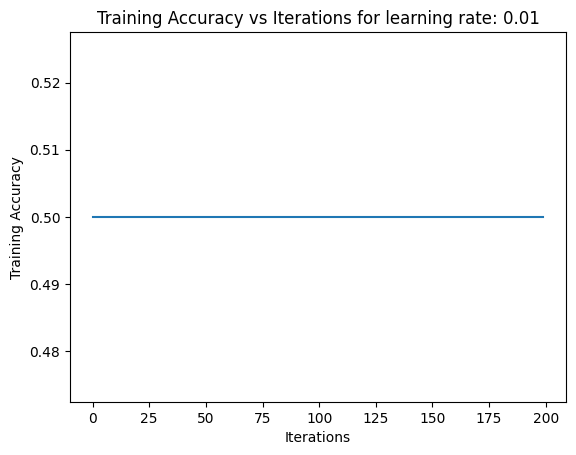

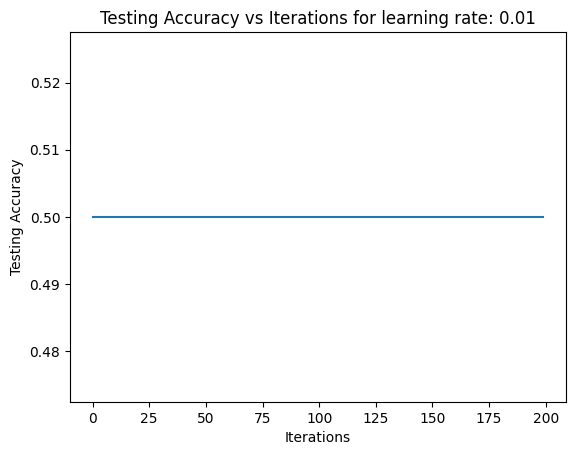

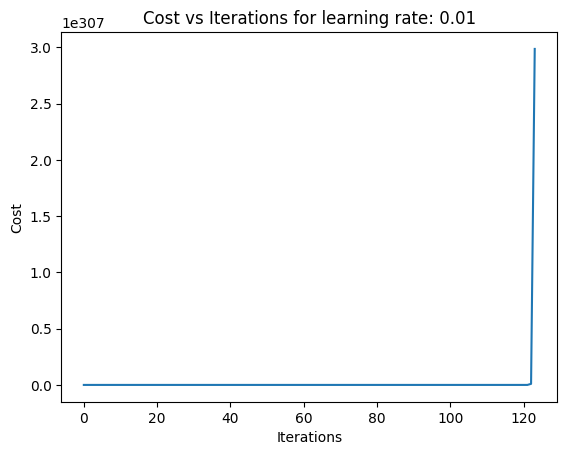

In [18]:
plot3Graphs(trnData,trnLabel,tstData,tstLabel,200,0.001)
plot3Graphs(trnData,trnLabel,tstData,tstLabel,200,0.01)

### 6.3 Report

How did you choose the learning rate and iteration number? Explain your results.

## 7. Advanced Gradient-based Training
For this section, you may choose to implement **either Option 1: SGD** (4 marks), or **Option 2: GD with hinge loss** (7 marks). 

*Please note: Option 1 is easier, but gives fewer potential marks. Option 2 is designed to be a steep challenge, potentially involves mathematical derivations not shown in your notes, and will be marked rigorously. Choose wisely!*

### Option 1: Compare with stochastic gradient descent training (4 marks, Normal)
### 7.1 SGD Implementation 
Replace the gradient descent approach that you did in Section 4 with a stochastic gradient descent approach. Your new implementation can be named as `lls_sgd_train`. You can adopt a similar implementation template to that of your `lls_gd_train` function.

In [19]:
def lls_sgd_train(data, labels, N, lr):
    """
    A summary of your function goes here.

    data: training data used for training model
    labels: training labels 
    N: number of iterations
    lr: learning rate
    
    Returns: cost and weights for each iteration into 2 arrays
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    X_tilde = np.hstack((np.ones((X.shape[0],1)),X))
    
    # Weight initialization
    w = np.zeros(X_tilde.shape[1])

    # Initialise arrays to store weights and cost at each iteration
    w_all = np.zeros((N, X_tilde.shape[1]))
    cost_all = []
    
    # SGD update of weights
    for i in range(N):
        # Randomly shuffle the data
        idx = np.random.randint(0, X_tilde.shape[0])
        X_shuffled = X_tilde[idx,None]
        y_shuffled = y[idx,None]
        
        # Compute gradient and cost
        gd = (X_shuffled.T@X_shuffled @ w) - (X_shuffled.T@y_shuffled)
        cost = np.sum(np.square(y-X_tilde@w)) / y.shape[0]
        
        # Weight update
        w -= lr * gd
        # save w and cost of each iteration in w_all and cost_all
        w_all[i,:] = w
        cost_all.append(cost)
        
      
    # Return model parameters.
    return cost_all, w_all

### 7.2 Experiment Design
Design and implement an appropriate experiment to demonstrate the performance and behaviour difference between gradient descent and stochastic gradient descent. 


In [20]:
import time
def plot3GraphsSGDvsGD(trnData,trnLabel,tstData,tstLabel,cstSGD,wgtSGD,cstGD,wgtGD):
    test_acc_SGD = []
    train_acc_SGD = []
    test_acc_GD = []
    train_acc_GD = []
    
    #Obtain training and testing accuracy for SGD
    for i in range(len(wgtSGD)):
        test_pred_SGD = lls_gd_pred(tstData, wgtSGD[i], tstLabel)
        test_acc_SGD.append((test_pred_SGD == tstLabel).mean())
        
        train_pred_SGD = lls_gd_pred(trnData, wgtSGD[i], trnLabel)
        train_acc_SGD.append((train_pred_SGD == trnLabel).mean())

    #obtain training and testing accuracy for GD
    for i in range(len(wgtGD)):
        test_pred_GD = lls_gd_pred(tstData, wgtGD[i], tstLabel)
        test_acc_GD.append((test_pred_GD == tstLabel).mean())
        
        train_pred_GD = lls_gd_pred(trnData, wgtGD[i], trnLabel)
        train_acc_GD.append((train_pred_GD == trnLabel).mean())
        
    # Plot training accuracy
    plt.plot(range(len(train_acc_SGD)), train_acc_SGD, label='SGD')
    plt.plot(range(len(train_acc_GD)), train_acc_GD, label='GD')
    plt.xlabel('Iterations')
    plt.ylabel('Training Accuracy')
    plt.title('Training Accuracy for SGD vs GD')
    plt.legend()
    plt.show()

    # Plot testing accuracy
    plt.plot(range(len(test_acc_SGD)), test_acc_SGD, label='SGD')
    plt.plot(range(len(test_acc_GD)), test_acc_GD, label='GD')
    plt.xlabel('Iterations')
    plt.ylabel('Testing Accuracy')
    plt.title('Testing Accuracy for SGD vs GD')
    plt.legend()
    plt.show()

    # Plot cost to iterations graph
    plt.plot(range(len(cstSGD)), cstSGD, label='SGD')
    plt.plot(range(len(cstGD)), cstGD, label='GD')
    plt.title('Cost vs Iterations for SGD vs GD')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.legend()
    plt.show()
      
def plotTimePerofrmanceSGDvsGD(trnData,trnLabel):
    iterations = np.arange(100, 801, 100)
    sgd_times = []
    gd_times = []

    #measure time taken for SGD and GD for each iteration
    for N in iterations:
        start = time.time()
        lls_sgd_train(trnData,trnLabel,N,0.001)
        end = time.time()
        sgd_times.append(end-start)
        
        start = time.time()
        lls_gd_train(trnData,trnLabel,N,0.001)
        end = time.time()
        gd_times.append(end-start)
        

    plt.plot(iterations, sgd_times, marker= 'o',label='SGD')
    plt.plot(iterations, gd_times, marker = 'o',label='GD')
    plt.xlabel('N')
    plt.ylabel('Running Time (s)')
    plt.title('Running Time of SGD vs GD')
    plt.legend()
    plt.show()

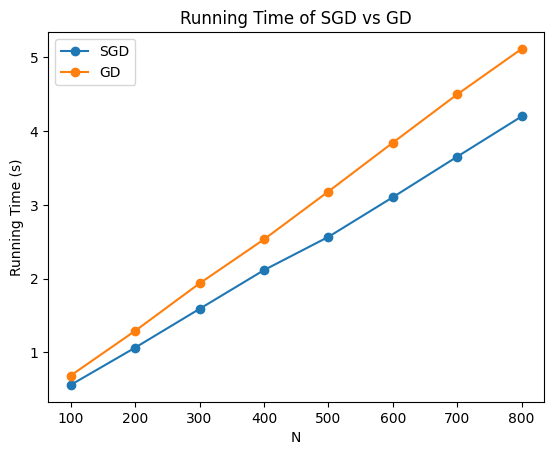

In [21]:
plotTimePerofrmanceSGDvsGD(trnData,trnLabel)

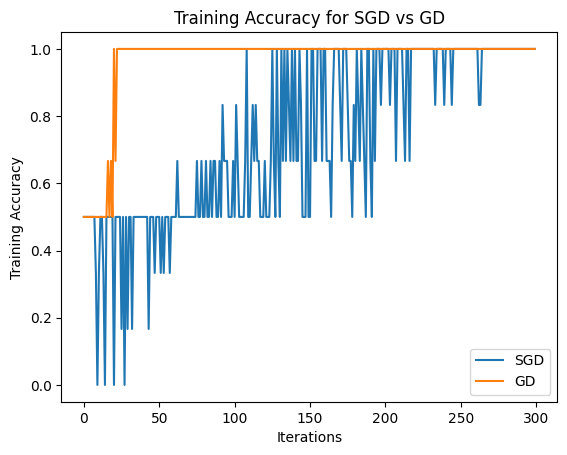

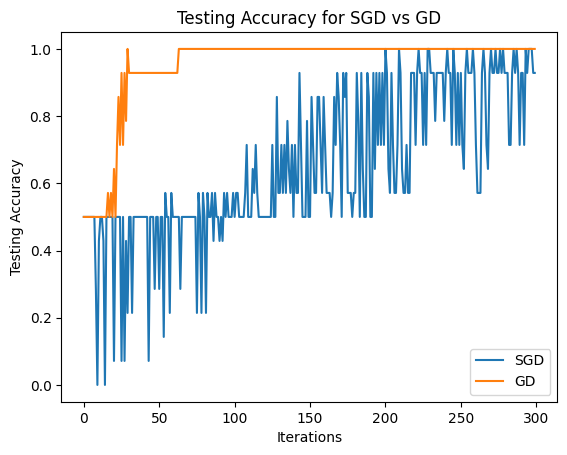

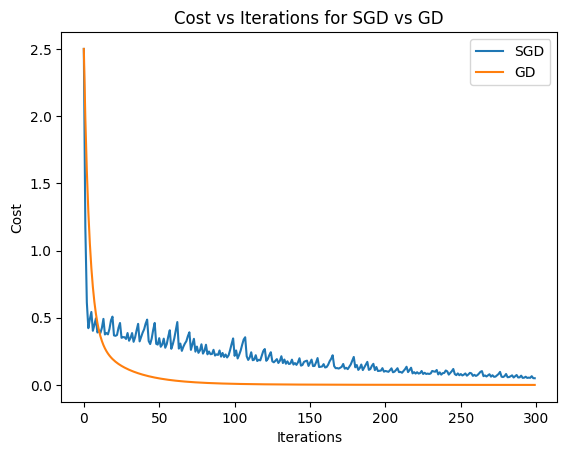

In [22]:
cstSGD, wgtSGD = lls_sgd_train(trnData, trnLabel, 300, 0.001)
cstGD, wgtGD = lls_gd_train(trnData, trnLabel, 300, 0.001)
plot3GraphsSGDvsGD(trnData, trnLabel, tstData, tstLabel, cstSGD, wgtSGD, cstGD, wgtGD)


### 7.3 Report

Explain in the report your experiment design, comparative result analysis and interpretation of obtained results. Try to be thorough in your analysis.

**Remember that all graphs should have axis labels and a title.**

### Option 2: Gradient descent training using hinge loss (7 marks, Hard)
Here is a recap of Hinge loss. For a single output model, the hinge loss over N training samples is $$O(\theta) = \sum^N_{i=1}\max\left(0, 1 - y_i f(\theta, x_i)\right)$$ where $y_i \in \{-1, +1\}$ is the class target label and $f(\theta, x_i)$ is your prediction function. While this is not directly differentiable, we can split it into two separately differentiable parts. For one sample, the above formuation is equivalent to:
$$
\max\left(0, 1 - y_i f(\theta, x_i)\right) = \begin{cases}
    0 & \text{if } y_i f(\theta, x_i) \geq 1 \\ % & is your "\tab"-like command (it's a tab alignment character)
    1-y_i f(\theta, x_i) & \text{otherwise.}
\end{cases}
$$

### 7.1 Implementation
Apply the gradient descent approach to train your classifier but by minimising the hinge loss. Implement the function `hinge_gd_train` below. 

`hinge_gd_train` trains a single-output linear model by minimising the hinge loss using the gradient descent approach. The optimisation function should include a regularisation term and regularisation hyperparameter $C$. It should take the iteration number $N$, the learning rate $\eta$, and regularisation hyperparameter $C$ as arguments. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of the regularised hinge loss model calculated in all the iterations.

In [23]:
def hinge_gd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):    
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    # This is just to be consistent with the lecture notes.
    X, y = data, labels

    # Initialise arrays to store weights and cost at each iteration
    w_all = ...
    cost_all = ...

    # Your code goes here
    
    # GD update of weights
    for i in range(N):
        # cost and gradient descent of the linear hinge loss model
        cost = ...
        
        # save w and cost of each iteration in w_all and cost_all


    # Return model parameters.
    return cost_all, w_all




### 7.2 Experiment design
Design and implement an appropriate experiment to demonstrate the performance and behaviour difference for gradient descent training based on the least squared loss and the hinge loss. 


In [24]:
# Your code goes here

### 7.3 Report

Explain in your report the following: 

(1) Your implementation of `hinge_gd_train`. If you analytically derived the loss function, please include it here.

(2) Your experiment design, comparative result analysis and interpretation of obtained results. 

**Remember that all graphs should have axis labels and a title.**